---
title: "Using R as a GIS"
author: "Kiefer"
date: "April 21, 2017"
output: md_document
---

In real estate, spatial data is the name of the game.  Countless programs in other domains utilize the power of this data, which is becoming more prevalent by the day.

In this post I will go over a few simple, but powerful tools to get you started using using geographic information in R.

In [2]:

##First, some libraries##
#install.packages('GISTools', dependencies = T)
library(GISTools)
library(knitr)

Loading required package: maptools
Loading required package: sp
Checking rgeos availability: TRUE
Loading required package: RColorBrewer
Loading required package: MASS
Loading required package: rgeos
rgeos version: 0.3-22, (SVN revision 544)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 r0 
 Linking to sp version: 1.2-4 
 Polygon checking: TRUE 



`GISTools` provides an easy-to-use method for creating shading schemes and choropleth maps.  Some of you may have heard of the `sp` package, which adds numerous spatial classes to the mix.  There are also functions for analysis and making things look nice.
  
  Let's get rolling: source the `vulgaris` dataset, which contains location information for Syringa Vulgaris (the Lilac) observation stations and US states.  This code plots the states and `vulgaris` points.

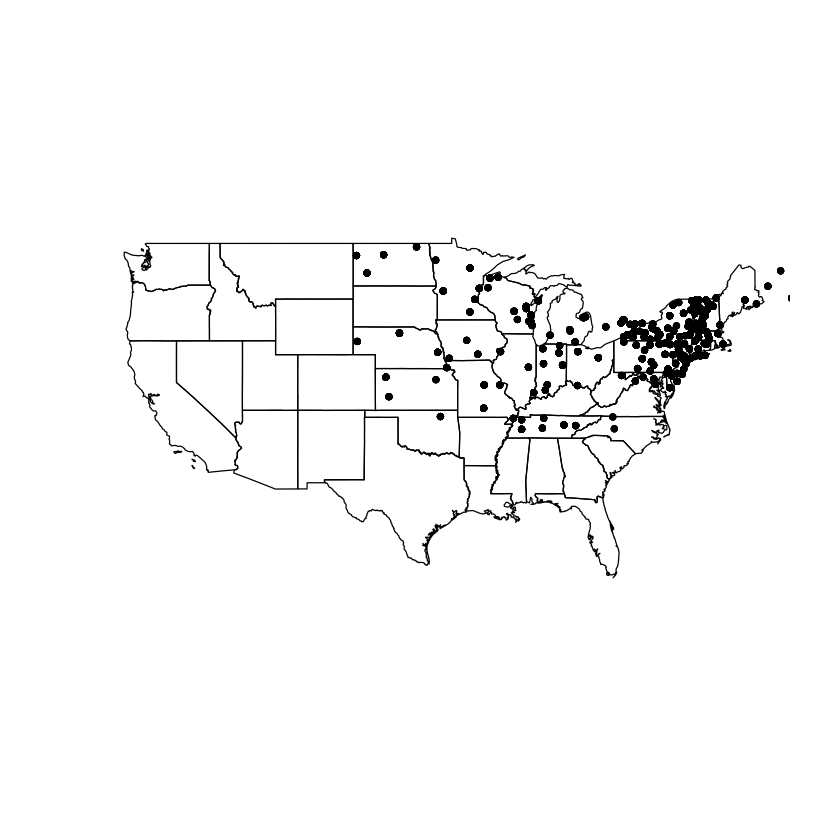

In [3]:

data("vulgaris")          #load data
par = (mar = c(2,0,0,0))  #set margins of plot area
plot(us_states)
plot(vulgaris, add = T, pch = 20)

One thing to note here is the structure of these objects.  `us_states` is a SpatialPolygonsDataFrame, which stores information for plotting shapes (like a shapefile) within its attributes.  `vulgaris` by contrast is a SpatialPointsDataFrame, which contains data for plotting individual points.  Much like a `data.frame` and `$`, these objects harbor information that can be accessed via `@`.

In [ ]:
%%R
us_states@polygons[[1]]  #returns a long list

In [5]:
head(vulgaris@data)

,Station,Year,Type,Leaf,Bloom,Station.Name,State.Prov,Lat,Long,Elev
3695,61689,1965,Vulgaris,114,136,COVENTRY,CT,41.8,-72.35,146
3696,61689,1966,Vulgaris,122,146,COVENTRY,CT,41.8,-72.35,146
3697,61689,1967,Vulgaris,104,156,COVENTRY,CT,41.8,-72.35,146
3698,61689,1968,Vulgaris,97,134,COVENTRY,CT,41.8,-72.35,146
3699,61689,1969,Vulgaris,114,138,COVENTRY,CT,41.8,-72.35,146
3700,61689,1970,Vulgaris,111,135,COVENTRY,CT,41.8,-72.35,146


Let's take a look at some functions that use this data.

In [13]:
newVulgaris <- gIntersection(us_states, vulgaris, byid = T)
(head(data.frame(newVulgaris)))

,x,y
3 4896,-67.65,44.65
3 4897,-67.65,44.65
3 4898,-67.65,44.65
3 4899,-67.65,44.65
3 4900,-67.65,44.65
3 4901,-67.65,44.65


`gIntersection`, as you may have guessed from the name, returns the intersection of two spatial objects.  In this case, we are given the points from `vulgaris` that are within `us_states`.  However, the rest of the `vulgaris` data has been stripped from the resulting object.  We've got to jump through a couple of hoops to get that information back.

In [14]:

newVulgaris <- data.frame(newVulgaris)
tmp <- rownames(newVulgaris)
tmp <- strsplit(tmp, " ")
tmp <- (sapply(tmp, "[[", 2))
tmp <- as.numeric(tmp)
vdf <- data.frame(vulgaris)
newVulgaris <- subset(vdf, row.names(vdf) %in% tmp)

In [17]:

head(newVulgaris)

,Station,Year,Type,Leaf,Bloom,Station.Name,State.Prov,Lat,Long,Elev,Long.1,Lat.1,optional
3695,61689,1965,Vulgaris,114,136,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE
3696,61689,1966,Vulgaris,122,146,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE
3697,61689,1967,Vulgaris,104,156,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE
3698,61689,1968,Vulgaris,97,134,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE
3699,61689,1969,Vulgaris,114,138,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE
3700,61689,1970,Vulgaris,111,135,COVENTRY,CT,41.8,-72.35,146,-72.35,41.8,TRUE


Look familiar?  Now we've got a data frame with the clipped `vulgaris` values and original data preserved.

In [18]:
vulgarisSpatial <- SpatialPointsDataFrame(data.frame(newVulgaris$Long, newVulgaris$Lat), newVulgaris, proj4string = CRS(proj4string(vulgaris)), bbox = vulgaris@bbox)

After storing our clipped data frame as a SpatialPointsDataFrame, we can again make use of it - in this case we add a shading scheme to the `vulgaris` points.

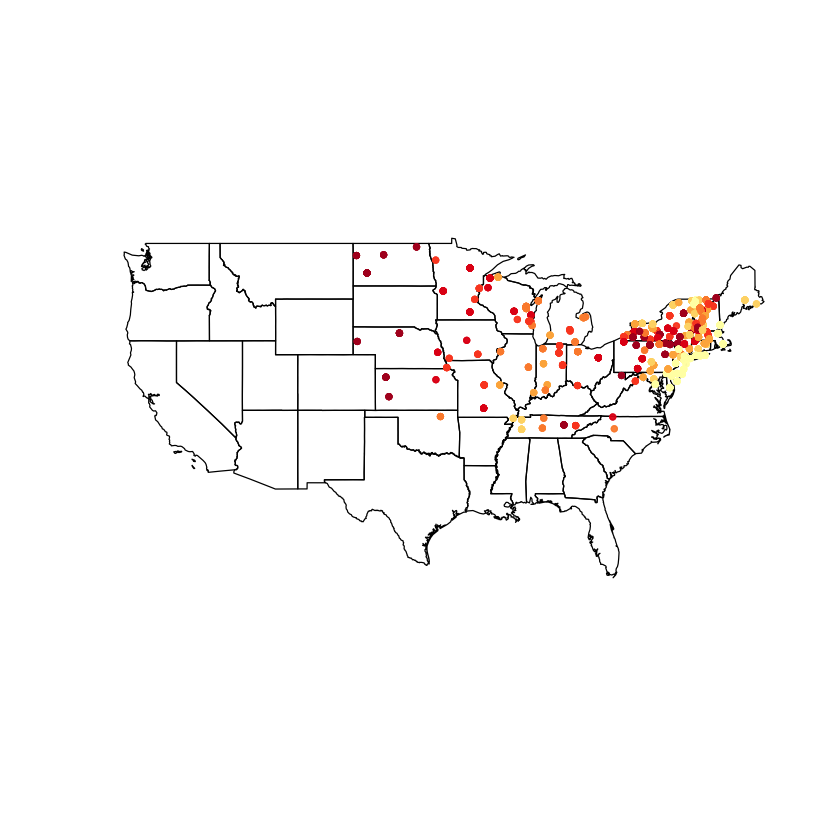

In [19]:
shades <- auto.shading(vulgarisSpatial@data$Elev, n = 7, cols = brewer.pal(7, 'YlOrRd'))  #Check cutter arg for more ways to create breaks.
shades$cols <- add.alpha(shades$cols, .5)
plot(us_states)
choropleth(vulgarisSpatial, vulgarisSpatial$Elev,shading = shades, add = T, pch = 20)

Colors are pretty, but what do they mean?  Let's add a legend.

In [20]:

us_states@bbox #Get us_states bounding box coordinates.

,min,max
r1,-124.73142,-66.96985
r2,24.95597,49.37173


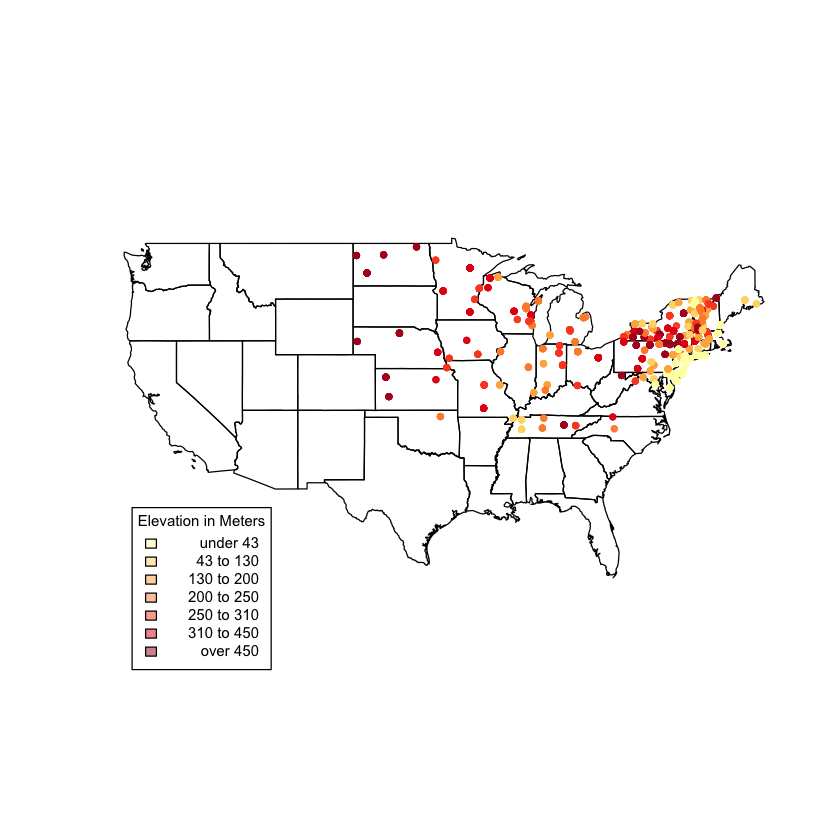

In [21]:

plot(us_states)
choropleth(vulgarisSpatial, vulgarisSpatial$Elev,shading = shades, add = T, pch = 20)
par(xpd=TRUE)           #Allow plotting outside of plot area.
choro.legend(-124, 30, shades, cex = .75, title = "Elevation in Meters") # Plot legend in bottom left.  Takes standard legend() params.

It looks like there's a lot going on in the Northeastern states.  For a closer look, create another clipping (like above) and plot it.  Using the structure below, we can create a selection vector.  I have hidden the full code since it is repetitive (check GitHub for the full code.)

In [22]:

index <- us_states$STATE_NAME == "Pennsylvania"
         '...'

[1] "..."

In [23]:

index <- us_states$STATE_NAME == "Pennsylvania"|
     us_states$STATE_NAME == "Maryland" |
     us_states$STATE_NAME == "Delaware" |
     us_states$STATE_NAME == "New Jersey" |
     us_states$STATE_NAME == "New York" |
     us_states$STATE_NAME == "Connecticut" |
     us_states$STATE_NAME == "Massachusetts" |
     us_states$STATE_NAME == "Vermont" |
     us_states$STATE_NAME == "New Hampshire" |
     us_states$STATE_NAME == "Maine"

In [24]:

northE <- us_states[index,]
vulgarisNE <- gIntersection(northE, vulgaris, byid = T)

clipped_to_spatial <- function(clipped, original){
clipped <- data.frame(clipped)
tmp <- rownames(clipped)
tmp <- strsplit(tmp, " ")
tmp <- (sapply(tmp, "[[", 2))
tmp <- as.numeric(tmp)
df <- data.frame(original)
clipped <- subset(df, row.names(df) %in% tmp)

spatial <- SpatialPointsDataFrame(data.frame(clipped$Long, clipped$Lat), clipped, proj4string = CRS(proj4string(original)), bbox = original@bbox)
return(spatial)
}
vulgarisNE <- clipped_to_spatial(vulgarisNE, vulgaris)

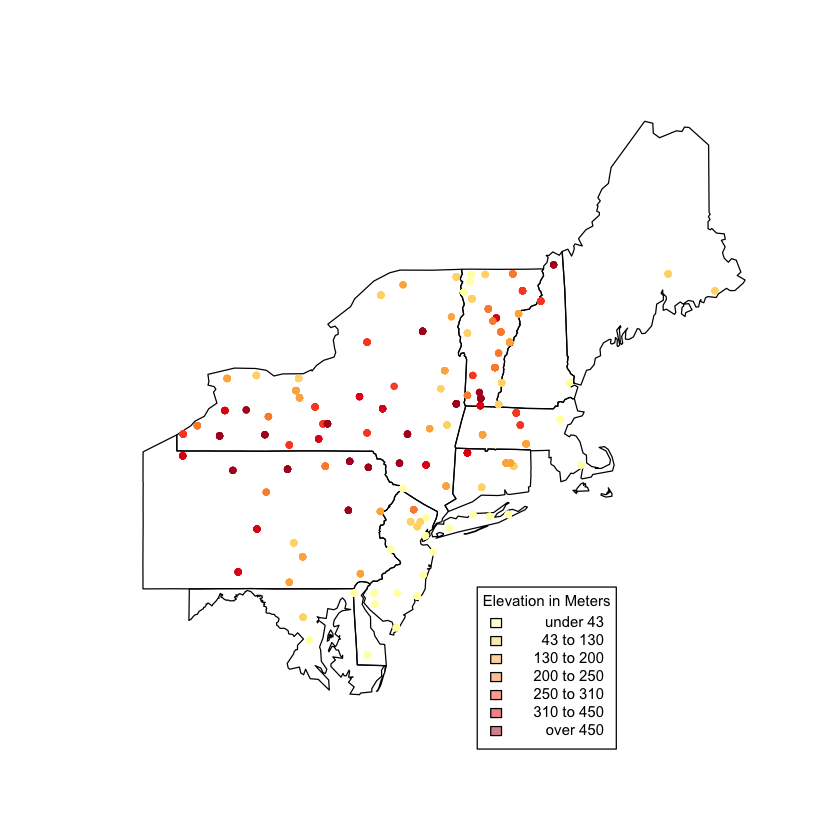

In [25]:

plot(us_states[index,])
choropleth(vulgarisNE, vulgarisNE$Elev,shading = shades, add = T, pch = 20)
par(xpd = T)
choro.legend(-73, 39.75, shades, cex = .75, title = "Elevation in Meters")

Hopefully this has been a useful introduction (or refresher) on spatial data.  I always learn a lot in the process of writing these posts.  If you have any comments or suggetions please leave a comment or feel free to contact me!

Happy mapping,

Kiefer